In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Using features: ['Age', 'Age_50plus', 'Age_Squared', 'Gender', 'Blood_Group', 'Blood_Rh', 'Billing Amount', 'Billing_per_Day', 'High_Biller', 'Test Results', 'Test_Abnormal', 'Urgent_Admission']
Class distribution: Counter({1: 1366, 2: 1363, 4: 1350, 0: 1320, 5: 1303, 3: 1298})
Categorical features: ['Gender', 'Blood_Group', 'Test Results']


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2325400	test: 0.1613829	best: 0.1613829 (0)	total: 212ms	remaining: 5m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1711289232
bestIteration = 1

Shrink model to first 2 iterations.

=== MODEL EVALUATION ===
Balanced Accuracy: 0.17217525429242506

Classification Report:
              precision    recall  f1-score   support

   Arthritis       0.14      0.17      0.16       330
      Asthma       0.21      0.16      0.18       342
      Cancer       0.16      0.13      0.14       340
    Diabetes       0.17      0.14      0.16       325
Hypertension       0.19      0.21      0.20       338
     Obesity       0.17      0.22      0.19       325

    accuracy                           0.17      2000
   macro avg       0.17      0.17      0.17      2000
weighted avg       0.17      0.17      0.17      2000



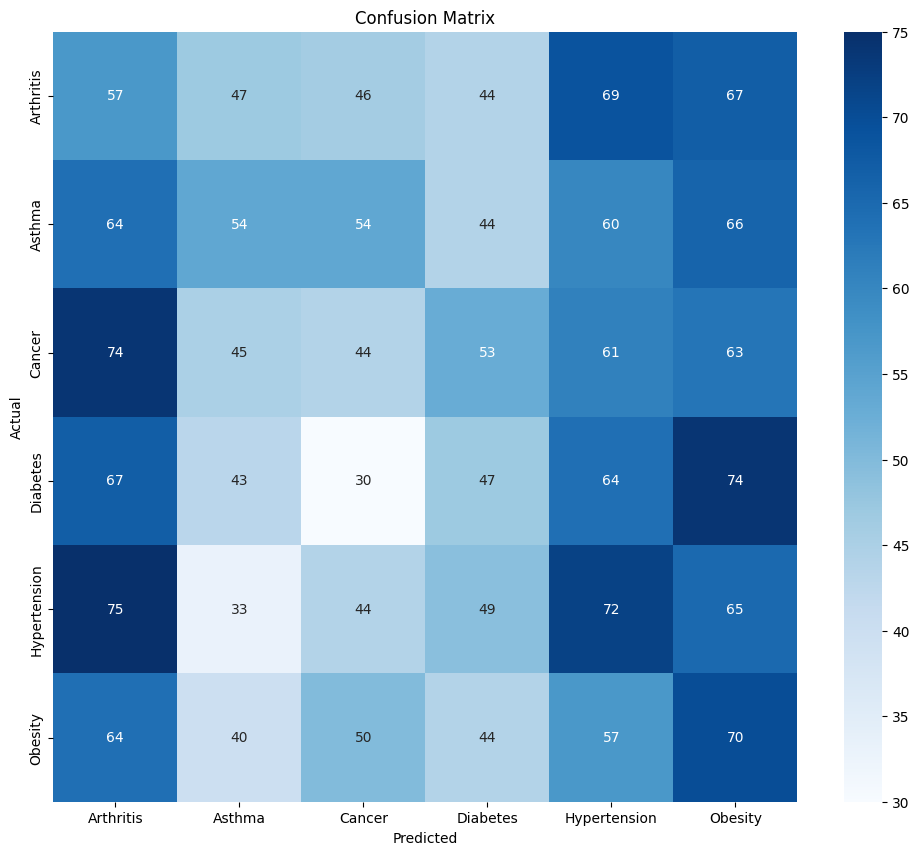

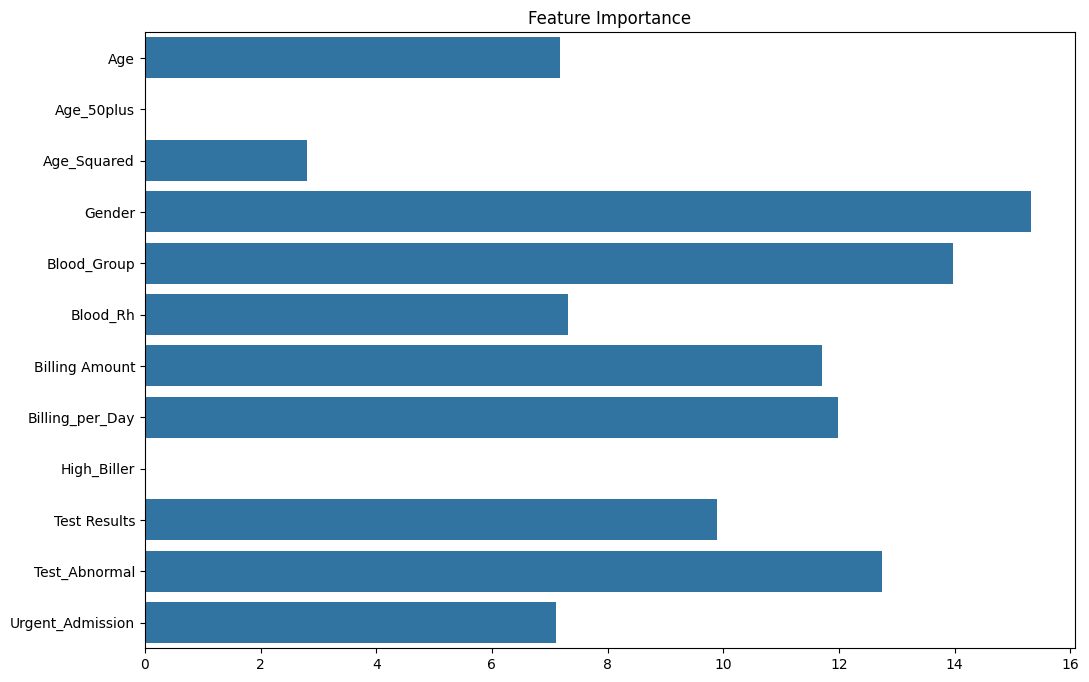

In [ ]:
# ======================
# 1. IMPORT LIBRARIES
# ======================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# 2. DATA LOADING & FEATURE ENGINEERING
# ======================
df = pd.read_csv("healthcare_dataset.csv")

# Convert target
le = LabelEncoder()
df["target"] = le.fit_transform(df["Medical Condition"])

# Calculate proper class weights
classes = np.unique(df["target"])
class_weights = compute_class_weight('balanced', classes=classes, y=df["target"])
class_weights_dict = dict(zip(classes, class_weights))

# Feature engineering
def create_features(df):
    df = df.copy()

    # Age features
    df['Age_50plus'] = (df['Age'] > 50).astype(int)
    df['Age_Squared'] = df['Age']**2

    # Blood type features
    if 'Blood Type' in df.columns:
        df['Blood_Rh'] = df['Blood Type'].str.contains('+', regex=False).fillna(0).astype(int)
        df['Blood_Group'] = df['Blood Type'].str[0].fillna('Unknown')

    # Billing features
    if 'Billing Amount' in df.columns:
        if 'Date of Admission' in df.columns and 'Discharge Date' in df.columns:
            df['Length_of_Stay'] = (pd.to_datetime(df['Discharge Date']) -
                                  pd.to_datetime(df['Date of Admission'])).dt.days
            df['Length_of_Stay'] = df['Length_of_Stay'].fillna(1)
            df['Billing_per_Day'] = df['Billing Amount'] / df['Length_of_Stay']
        else:
            df['Billing_per_Day'] = df['Billing Amount']

        df['High_Biller'] = (df['Billing Amount'] > df['Billing Amount'].quantile(0.75)).astype(int)

    # Admission features
    if 'Admission Type' in df.columns:
        df['Urgent_Admission'] = df['Admission Type'].isin(['Emergency', 'Urgent']).astype(int)

    # Test Results
    if 'Test Results' in df.columns:
        df['Test_Abnormal'] = df['Test Results'].str.contains('Abnormal', regex=False).astype(int)

    return df

df = create_features(df)

# ======================
# 3. DATA PREPARATION
# ======================
# Select available features
possible_features = [
    'Age', 'Age_50plus', 'Age_Squared', 'Gender',
    'Blood_Group', 'Blood_Rh', 'Billing Amount',
    'Billing_per_Day', 'High_Biller', 'Test Results',
    'Test_Abnormal', 'Urgent_Admission'
]
features = [f for f in possible_features if f in df.columns]
print(f"Using features: {features}")

X = df[features]
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE if needed
class_counts = Counter(y_train)
if len(class_counts) > 1 and min(class_counts.values()) < 100:
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print(f"Class distribution after SMOTE: {Counter(y_train_res)}")
else:
    X_train_res, y_train_res = X_train, y_train
    print(f"Class distribution: {class_counts}")

# ======================
# 4. MODEL TRAINING
# ======================
# Identify categorical features
cat_features = [col for col in features if df[col].dtype == 'object' and df[col].nunique() < 50]
print(f"Categorical features: {cat_features}")

model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    auto_class_weights='Balanced',  # Correct CatBoost parameter
    cat_features=cat_features,
    random_state=42,
    early_stopping_rounds=50,
    verbose=100
)

model.fit(
    X_train_res, y_train_res,
    eval_set=(X_test, y_test),
    plot=True
)

# ======================
# 5. EVALUATION
# ======================
y_pred = model.predict(X_test)

print("\n=== MODEL EVALUATION ===")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(le.inverse_transform(y_test),
                          le.inverse_transform(y_pred)))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x=model.get_feature_importance(), y=features)
plt.title('Feature Importance')
plt.show()

Support for third party widgets will remain active for the duration of the session. To disable support: